In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from utils import *

simplefilter(action='ignore', category=FutureWarning)

In [2]:
hadex_rx1day = xr.open_dataset('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/HadEX3/HadEX3-0-4_rx1day_ann.nc')
hadex_rx1day = hadex_rx1day['Rx1day']
hadex_rx1day = hadex_rx1day.rename({'longitude':'lon','latitude':'lat'})
hadex_rx1day = hadex_rx1day.sel(time=slice('1960','2014'))

hadex_rx1day_not_null = ~hadex_rx1day.isnull()
hadex_rx1day_not_null_sum = hadex_rx1day_not_null.sum(axis=0,skipna=True)
hadex_rx1day_grid_sel = hadex_rx1day_not_null_sum >= (2014-1960+1) * 0.85
hadex_rx1day_grid_sel = hadex_rx1day_grid_sel.where(hadex_rx1day_grid_sel>0)
hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel

# hadex_rx1day_grid_sel.to_netcdf('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/shapefile/hadex_region.nc')

## Calculate rx1day time series for CMIP6 simulations with respective to 1960~2014 

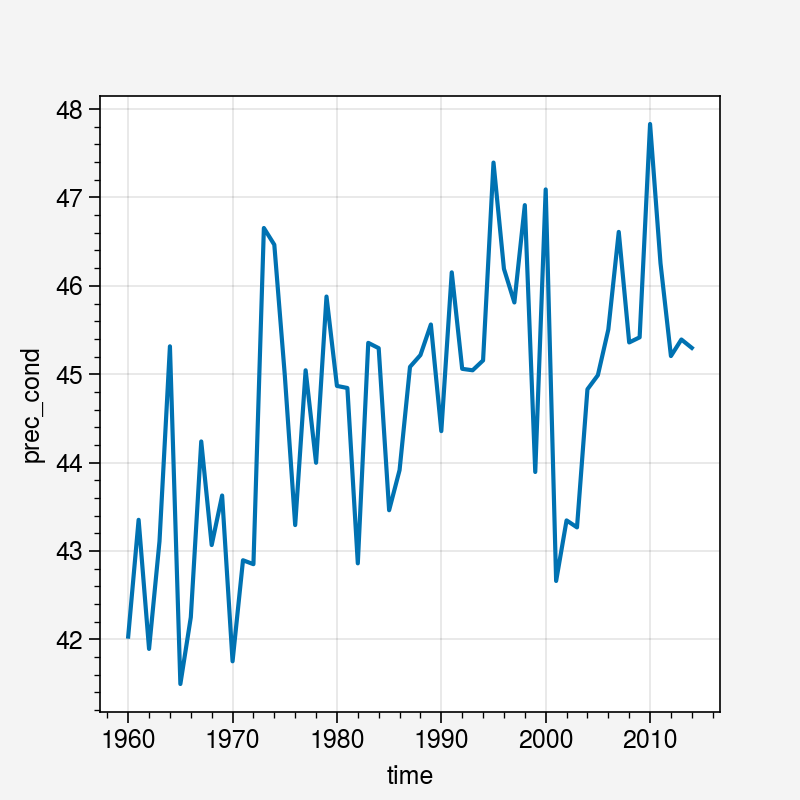

In [3]:
era5_scaling_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='Global')
era5_scaling_hist = era5_scaling_hist.regrid()

era5_scaling_hist = spatial_weighted_mean(era5_scaling_hist)
era5_scaling_hist['prec_cond'].plot()

In [4]:
prec_cmip6 = pd.DataFrame()

name_ens = 'prec'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]

for i in range(len(ensemble)):
    i = ensemble[i]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    area_weights = np.cos(np.deg2rad((ens_i_regrid.lat)))
    area_weights.name = 'weights'
    prec_weighted = ens_i_regrid.weighted(area_weights)
    prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
    prec_weighted_mean = prec_weighted_mean['prec_cond']
    prec_cmip6[i] = prec_weighted_mean
    
prec_cmip6 = prec_cmip6 - prec_cmip6.mean(axis=0)
prec_005   = prec_cmip6.apply(lambda x: x.quantile(0.05),axis=1)
prec_095   = prec_cmip6.apply(lambda x: x.quantile(0.95),axis=1)
prec_mean  = prec_cmip6.mean(axis=1)
prec_cmip6['prec_mean'] = prec_mean
prec_cmip6['prec_005']  = prec_005
prec_cmip6['prec_095']  = prec_095


scaling_cmip6 = pd.DataFrame()

for i in range(len(ensemble)):
    i = ensemble[i]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    area_weights = np.cos(np.deg2rad((ens_i_regrid.lat)))
    area_weights.name = 'weights'
    scaling_weighted = ens_i_regrid.weighted(area_weights)
    scaling_weighted_mean = scaling_weighted.mean(("lon", "lat"),skipna=True)
    scaling_weighted_mean = scaling_weighted_mean['scaling']
    scaling_cmip6[i] = scaling_weighted_mean
    
scaling_cmip6 = scaling_cmip6 - scaling_cmip6.mean(axis=0)
scaling_005   = scaling_cmip6.apply(lambda x: x.quantile(0.05),axis=1)
scaling_095   = scaling_cmip6.apply(lambda x: x.quantile(0.95),axis=1)
scaling_mean  = scaling_cmip6.mean(axis=1)
scaling_cmip6['scaling_mean'] = scaling_mean
scaling_cmip6['scaling_005']  = scaling_005
scaling_cmip6['scaling_095']  = scaling_095


<AxesSubplot:>

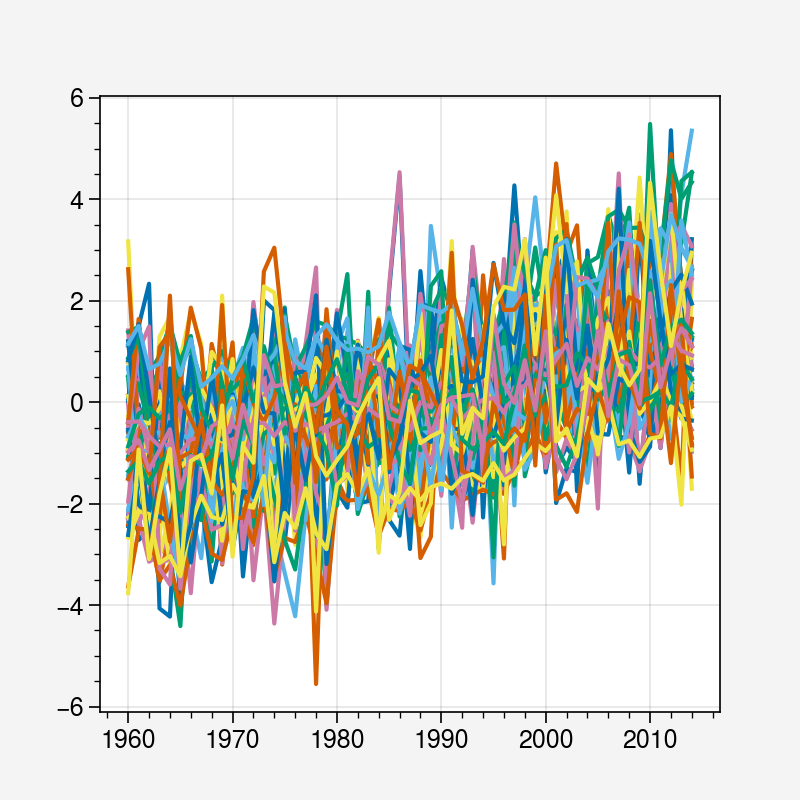

In [5]:
ts_data_ano = pd.concat([prec_cmip6,scaling_cmip6],axis=1)

# ERA5
prec_era5 = Rx1dayCond(name='prec',forcing='era5',src_id='era5',run='reanalysis',mask='Global')
prec_era5 = prec_era5.regrid()
prec_era5 = prec_era5.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((prec_era5.lat)))
area_weights.name = 'weights'
prec_weighted = prec_era5.weighted(area_weights)
prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
prec_weighted_mean_era5 = prec_weighted_mean['prec_cond']
prec_weighted_mean_era5 = prec_weighted_mean_era5 - prec_weighted_mean_era5.mean()

scaling_era5 = Rx1dayCond(name='scaling',forcing='era5',src_id='era5',run='reanalysis',mask='Global')
scaling_era5 = scaling_era5.regrid()
scaling_era5 = scaling_era5.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_era5.lat)))
area_weights.name = 'weights'
scaling_weighted = scaling_era5.weighted(area_weights)
scaling_weighted_mean = scaling_weighted.mean(("lon", "lat"),skipna=True)
scaling_weighted_mean_era5 = scaling_weighted_mean['scaling']
scaling_weighted_mean_era5 = scaling_weighted_mean_era5 - scaling_weighted_mean_era5.mean()

# JRA55
prec_jra55 = Rx1dayCond(name='prec',forcing='jra55',src_id='jra55',run='reanalysis',mask='Global')
prec_jra55 = prec_jra55.regrid()
prec_jra55 = prec_jra55.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((prec_jra55.lat)))
area_weights.name = 'weights'
prec_weighted = prec_jra55.weighted(area_weights)
prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
prec_weighted_mean_jra55 = prec_weighted_mean['prec_cond']
prec_weighted_mean_jra55 = prec_weighted_mean_jra55 - prec_weighted_mean_jra55.mean()

scaling_jra55 = Rx1dayCond(name='scaling',forcing='jra55',src_id='jra55',run='reanalysis',mask='Global')
scaling_jra55 = scaling_jra55.regrid()
scaling_jra55 = scaling_jra55.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_jra55.lat)))
area_weights.name = 'weights'
scaling_weighted = scaling_jra55.weighted(area_weights)
scaling_weighted_mean = scaling_weighted.mean(("lon", "lat"),skipna=True)
scaling_weighted_mean_jra55 = scaling_weighted_mean['scaling']
scaling_weighted_mean_jra55 = scaling_weighted_mean_jra55 - scaling_weighted_mean_jra55.mean()

# hadex3
area_weights = np.cos(np.deg2rad((hadex_rx1day_sel.lat)))
area_weights.name = 'weights'
hadex_weighted = hadex_rx1day_sel.weighted(area_weights)
hadex_weighted_mean = hadex_weighted.mean(("lon", "lat"),skipna=True)
hadex_weighted_mean = hadex_weighted_mean - hadex_weighted_mean.mean()

ts_data_ano['prec_era5'] = prec_weighted_mean_era5
ts_data_ano['scaling_era5'] = scaling_weighted_mean_era5
ts_data_ano['prec_jra55'] = prec_weighted_mean_jra55
ts_data_ano['scaling_jra55'] = scaling_weighted_mean_jra55
ts_data_ano['hadex'] = hadex_weighted_mean

ts_data_ano = ts_data_ano.set_axis(range(1960,2015),axis=0)

ts_data_ano.plot(legend=False)


<AxesSubplot:>

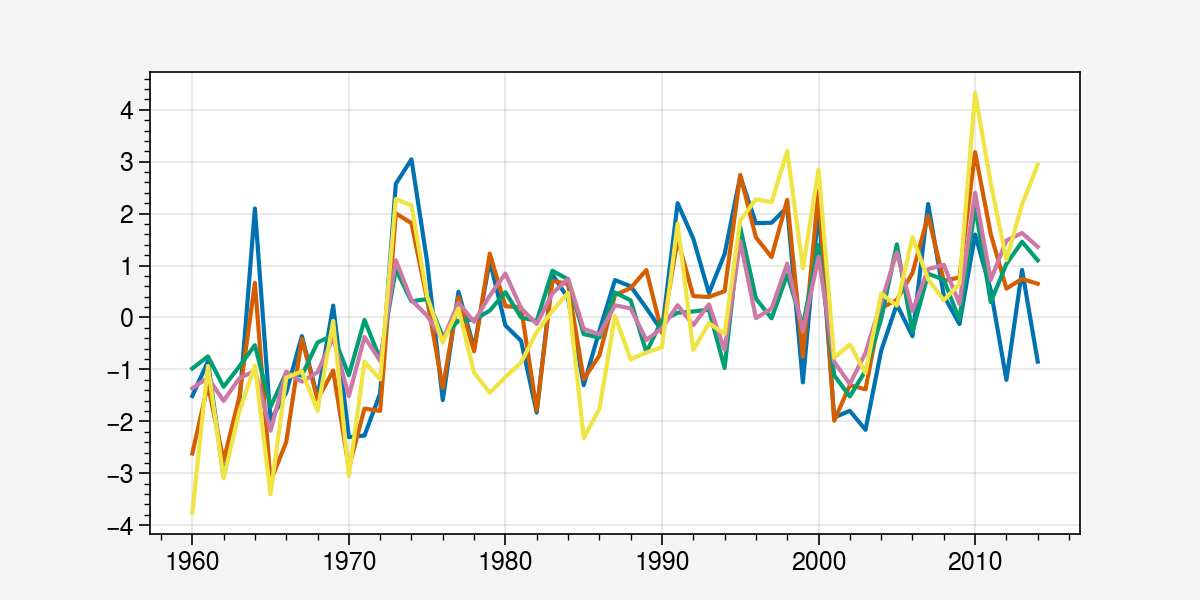

In [6]:
fig = plt.figure(figsize=(6, 3))
ts_data_ano['scaling_era5'].plot()
ts_data_ano['prec_era5'].plot()
ts_data_ano['scaling_jra55'].plot()
ts_data_ano['prec_jra55'].plot()
ts_data_ano['hadex'].plot()

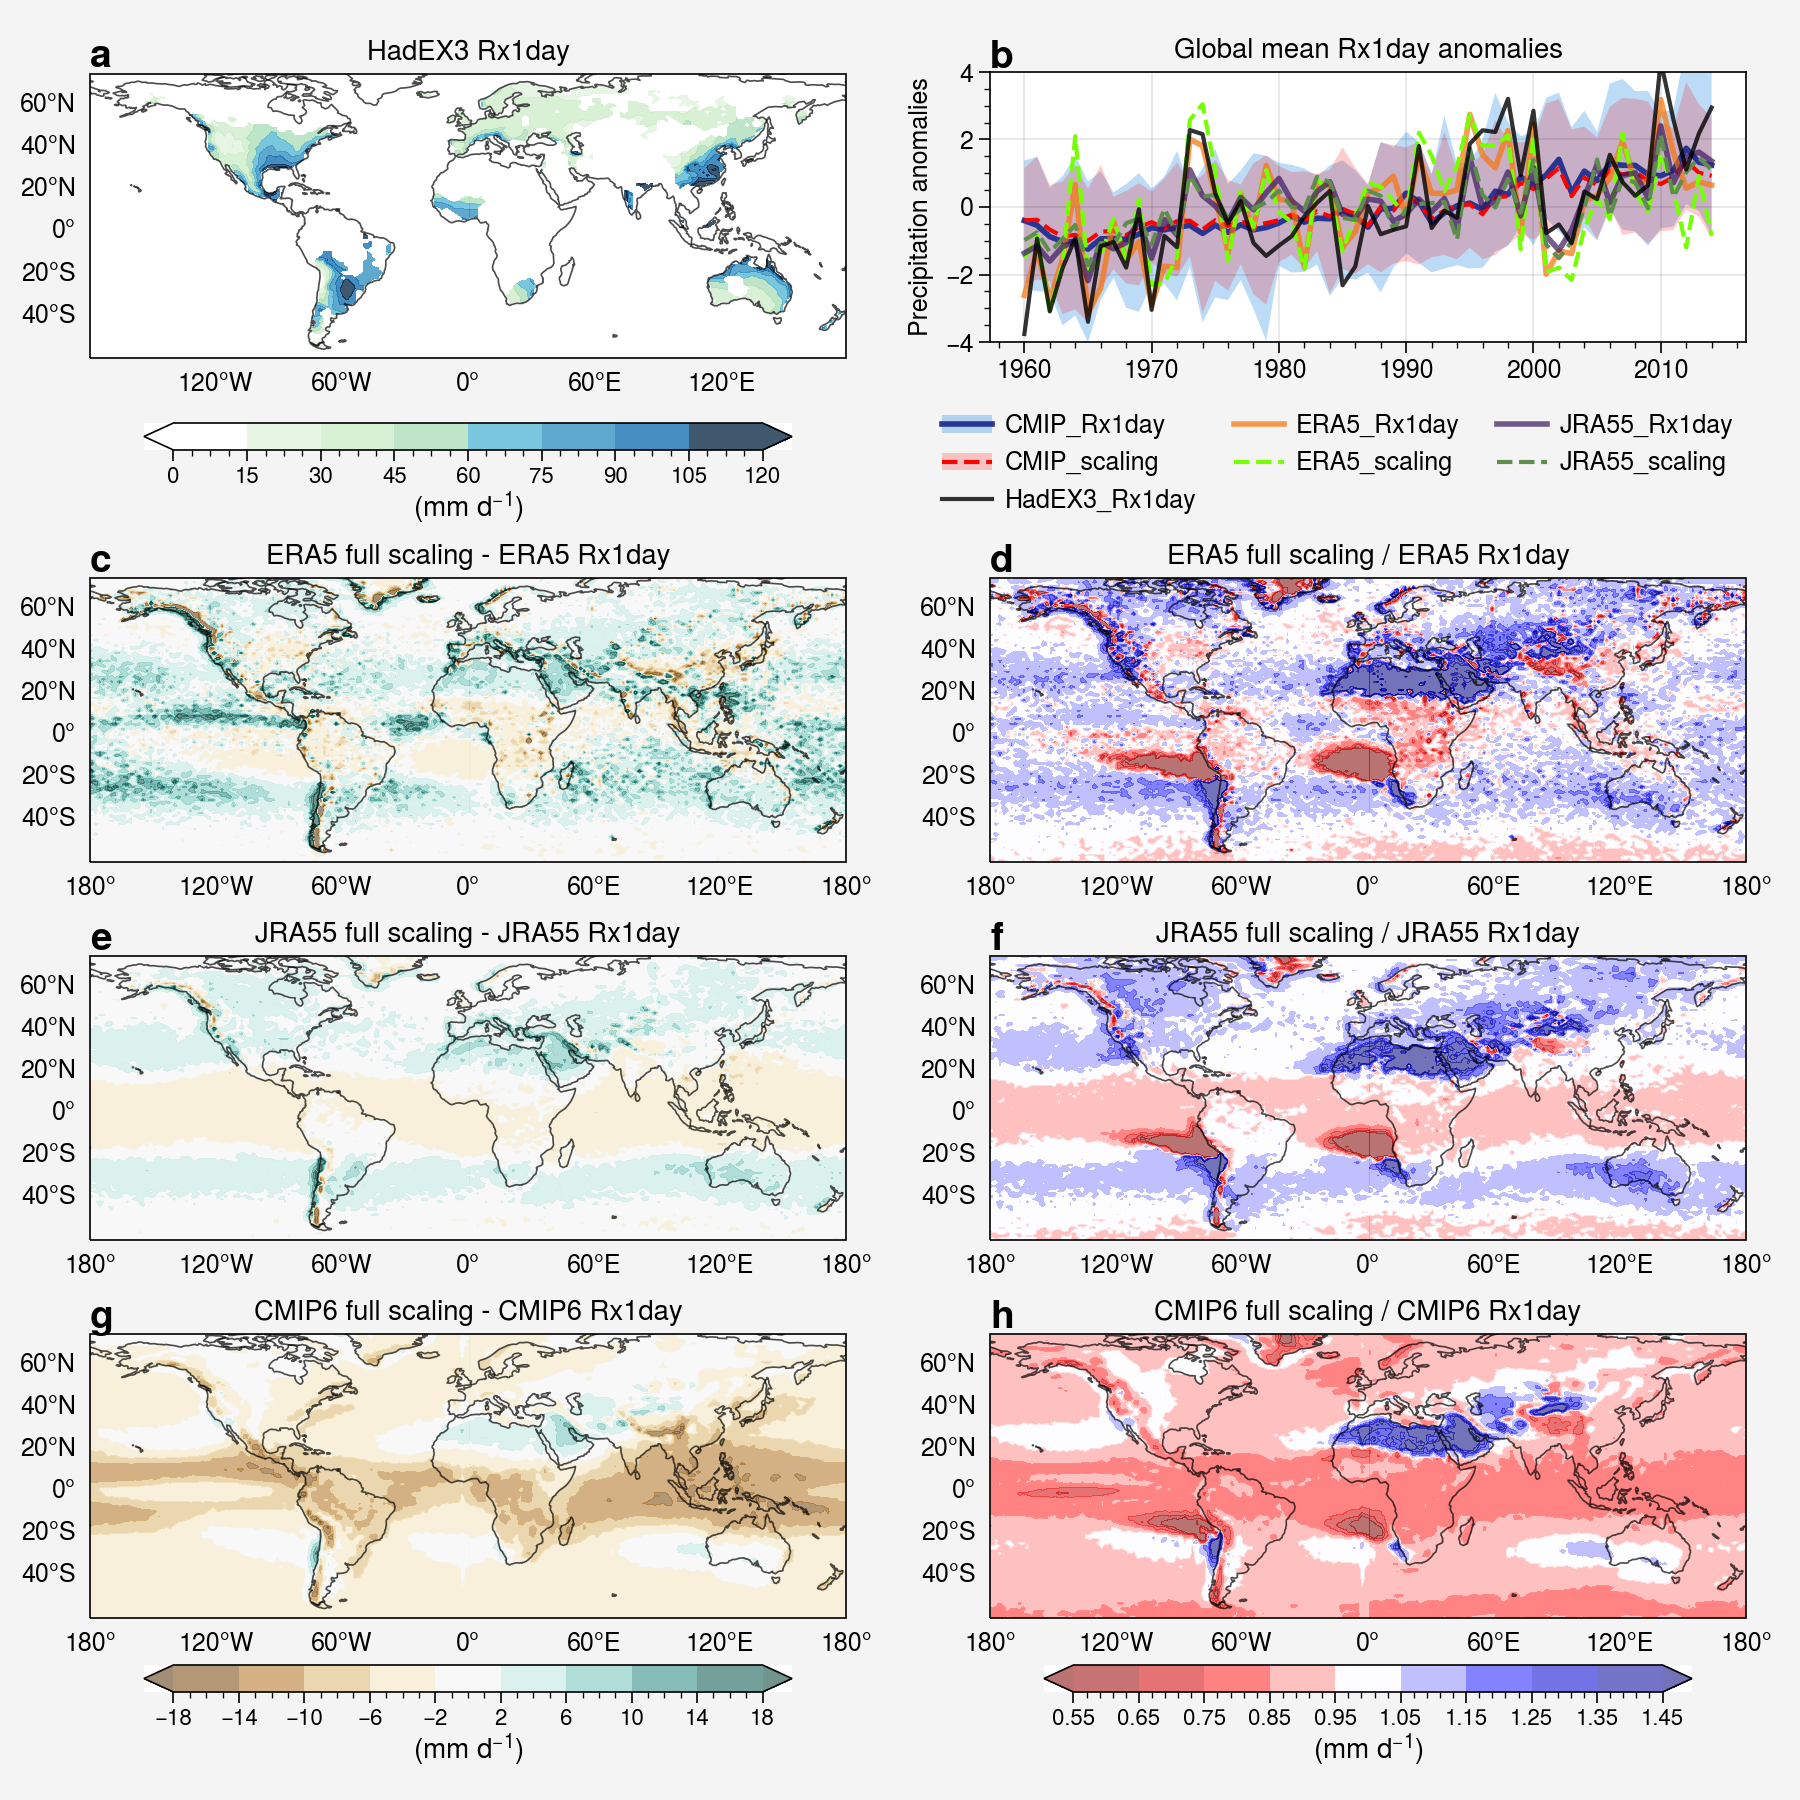

In [16]:
fig = plt.figure(figsize = (9, 9))

abc_label = ['a','b','c','d','e','f','g','h']
ax_anchor = [
    [0.05,0.79,0.42,0.18],
    [0.55,0.81,0.42,0.15],
    [0.05,0.51,0.42,0.18],
    [0.55,0.51,0.42,0.18],
    [0.05,0.3,0.42,0.18],
    [0.55,0.3,0.42,0.18],
    [0.05,0.09,0.42,0.18],
    [0.55,0.09,0.42,0.18]
]

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

vmax = 120
vmin = 0
vmax1 = 18
vmin1 = -18
vmax2 = 1.45
vmin2 = 0.55
levels = 10
cmap0 = cmaps.CBR_wet
cmap2 = cmaps.BlWhRe_r
cmap1 = cmaps.MPL_BrBG

hadex_region = shpreader.Reader('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/shapefile/hadex_region.shp')
hadex_feature = ShapelyFeature(hadex_region.geometries(), ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='none', edgecolor='black', lw=0.8)

# row1,col1 for Hadex3 Rx1day
ax1 = fig.add_axes(ax_anchor[0], projection = mapcrs)

hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
lons1d = hadex_rx1day_clim['lon']
lats1d = hadex_rx1day_clim['lat']
data1_hadex  = hadex_rx1day_clim
data1_hadex, lons1d = add_cyclic_point(data1_hadex, coord=lons1d)
p1 = ax1.contourf(lons1d,lats1d,data1_hadex,levels = [i for i in np.linspace(vmin,vmax,9)],alpha=0.75,extend = 'both',cmap=cmap0)
ax1.set_title('HadEX3 Rx1day')
ax1.set(ylim=(-60,75))

resol = '110m' 
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor='none', alpha=0.7)
ax1.add_feature(land, facecolor='none')
add_panel_label(ax1, 'a', x=0, y = 1.12)
gl = ax1.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row1,col2 for Rx1day anomalies
ax2 = fig.add_axes(ax_anchor[1])

a1 = ax2.fill_between(ts_data_ano.index, ts_data_ano['prec_005'], ts_data_ano['prec_095'],facecolor='#1E88E5',alpha=0.3)
b1 = ax2.fill_between(ts_data_ano.index, ts_data_ano['scaling_005'], ts_data_ano['scaling_095'], facecolor = 'red', alpha=0.2)
a2 = ax2.plot(ts_data_ano.index, ts_data_ano['prec_mean'], color='#283593',linewidth=2)
b2 = ax2.plot(ts_data_ano.index, ts_data_ano['scaling_mean'], color='red',linewidth=1.5,linestyle='dashed')
d  = ax2.plot(ts_data_ano.index, ts_data_ano['prec_era5'], color='orange',linewidth=2,alpha=0.7)
e  = ax2.plot(ts_data_ano.index, ts_data_ano['scaling_era5'], color='#76FF03',linewidth=1.5,linestyle='dashed')
f  = ax2.plot(ts_data_ano.index, ts_data_ano['prec_jra55'], color='#3B185F',linewidth=2,alpha=0.7)
g  = ax2.plot(ts_data_ano.index, ts_data_ano['scaling_jra55'], color='#5F8D4E',linewidth=1.5,linestyle='dashed')
k  = ax2.plot(ts_data_ano.index, ts_data_ano['hadex'], color='black',linewidth=1.5, alpha=0.8)
ax2.set_title('Global mean Rx1day anomalies')
ax2.set(ylim=(-4,4))
ax2.set_ylabel('Precipitation anomalies')
add_panel_label(ax2, 'b', x=0, y = 1.12)

ax2.legend(
    [(a1,a2[0]),(b1,b2[0]),k[0],d[0],e[0],f[0],g[0]], 
    ['CMIP_Rx1day','CMIP_scaling','HadEX3_Rx1day','ERA5_Rx1day','ERA5_scaling','JRA55_Rx1day','JRA55_scaling',],
    bbox_to_anchor=[1,-0.22],fancybox = False,frameon=False,
    ncol=3,fontsize=9)

# row2 for ERA5 Rx1day and full scaling
era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist = era5_prec_hist.regrid()
era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = era5_prec_hist['lon']
lats1d = era5_prec_hist['lat']
era5_prec_hist, lons1d = add_cyclic_point(era5_prec_hist, coord=lons1d)
era5_prec_hist[:,-2] = (era5_prec_hist[:,-3] + era5_prec_hist[:,-1]) / 2

era5_scaling_hist = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
era5_scaling_hist = era5_scaling_hist.regrid()
era5_scaling_hist = era5_scaling_hist.sel(time=slice('1960','2014'))
era5_scaling_hist = era5_scaling_hist['scaling'].mean(axis=0,skipna=True)
lons1d = era5_scaling_hist['lon']
lats1d = era5_scaling_hist['lat']
era5_scaling_hist, lons1d = add_cyclic_point(era5_scaling_hist, coord=lons1d)
era5_scaling_hist[:,-2] = (era5_scaling_hist[:,-3] + era5_scaling_hist[:,-1]) / 2

era5_prec_hist_delta  = era5_scaling_hist - era5_prec_hist
era5_prec_hist_ratio  = era5_scaling_hist / era5_prec_hist

ax3 = fig.add_axes(ax_anchor[2], projection = mapcrs)
p2 = ax3.contourf(lons1d,lats1d,era5_prec_hist_delta,alpha=0.55,levels = [i for i in np.linspace(vmin1,vmax1,levels)], extend = 'both',cmap=cmap1)
ax3.set(ylim=(-60,75))
ax3.set_title('ERA5 full scaling - ERA5 Rx1day')
ax3.add_feature(land, facecolor='none')
add_panel_label(ax3, 'c', x=0, y = 1.12)
gl = ax3.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

ax4 = fig.add_axes(ax_anchor[3], projection = mapcrs)
p2 = ax4.contourf(lons1d,lats1d,era5_prec_hist_ratio,alpha=0.55,levels = [i for i in np.linspace(vmin2,vmax2,levels)], extend = 'both',cmap=cmap2)
ax4.set(ylim=(-60,75))
ax4.set_title('ERA5 full scaling / ERA5 Rx1day')
ax4.add_feature(land, facecolor='none')
add_panel_label(ax4, 'd', x=0, y = 1.12)
gl = ax4.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row3 for jra55 Rx1day and full scaling
jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist = jra55_prec_hist.regrid()
jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = jra55_prec_hist['lon']
lats1d = jra55_prec_hist['lat']
jra55_prec_hist, lons1d = add_cyclic_point(jra55_prec_hist, coord=lons1d)
jra55_prec_hist[:,-2] = (jra55_prec_hist[:,-3] + jra55_prec_hist[:,-1]) / 2

jra55_scaling_hist = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
jra55_scaling_hist = jra55_scaling_hist.regrid()
jra55_scaling_hist = jra55_scaling_hist.sel(time=slice('1960','2014'))
jra55_scaling_hist = jra55_scaling_hist['scaling'].mean(axis=0,skipna=True)
lons1d = jra55_scaling_hist['lon']
lats1d = jra55_scaling_hist['lat']
jra55_scaling_hist, lons1d = add_cyclic_point(jra55_scaling_hist, coord=lons1d)
jra55_scaling_hist[:,-2] = (jra55_scaling_hist[:,-3] + jra55_scaling_hist[:,-1]) / 2

jra55_prec_hist_delta  = jra55_scaling_hist - jra55_prec_hist
jra55_prec_hist_ratio  = jra55_scaling_hist / jra55_prec_hist

ax5 = fig.add_axes(ax_anchor[4], projection = mapcrs)
p2 = ax5.contourf(lons1d,lats1d,jra55_prec_hist_delta,alpha=0.55,levels = [i for i in np.linspace(vmin1,vmax1,levels)], extend = 'both',cmap=cmap1)
ax5.set(ylim=(-60,75))
ax5.set_title('JRA55 full scaling - JRA55 Rx1day')
ax5.add_feature(land, facecolor='none')
add_panel_label(ax5, 'e', x=0, y = 1.12)
gl = ax5.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

ax6 = fig.add_axes(ax_anchor[5], projection = mapcrs)
p2 = ax6.contourf(lons1d,lats1d,jra55_prec_hist_ratio,alpha=0.55,levels = [i for i in np.linspace(vmin2,vmax2,levels)], extend = 'both',cmap=cmap2)
ax6.set(ylim=(-60,75))
ax6.set_title('JRA55 full scaling / JRA55 Rx1day')
ax6.add_feature(land, facecolor='none')
add_panel_label(ax6, 'f', x=0, y = 1.12)
gl = ax6.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row4 for CMIP6
ax7 = fig.add_axes(ax_anchor[6], projection = mapcrs)

name_ens = 'prec'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]
prec_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    # lons1d = ens_i_regrid['lon']
    ens_i_regrid = ens_i_regrid['prec_cond']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_regrid[:,-2] = (ens_i_regrid[:,-3] + ens_i_regrid[:,-1]) / 2
    prec_hist_mme[x,:,:] = ens_i_regrid
prec_hist_mme = np.nanmean(prec_hist_mme,axis=0)

name_ens = 'scaling'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]
scaling_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['scaling']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_regrid[:,-2] = (ens_i_regrid[:,-3] + ens_i_regrid[:,-1]) / 2
    scaling_hist_mme[x,:,:] = ens_i_regrid
scaling_hist_mme = np.nanmean(scaling_hist_mme,axis=0)

prec_hist_mme_delta  = scaling_hist_mme - prec_hist_mme
prec_hist_mme_delta[:,-1] = (prec_hist_mme_delta[:,0] + prec_hist_mme_delta[:,-2]) / 2
prec_hist_mme_delta = np.append(prec_hist_mme_delta, ((prec_hist_mme_delta[:,-1] + prec_hist_mme_delta[:,0])/2)[:,np.newaxis], axis=1)
p2 = ax7.contourf(lons1d,lats1d,prec_hist_mme_delta,alpha=0.55,levels = [i for i in np.linspace(vmin1,vmax1,levels)], extend = 'both',cmap=cmap1)
ax7.set(ylim=(-60,75))
ax7.set_title('CMIP6 full scaling - CMIP6 Rx1day')
ax7.add_feature(land, facecolor='none')
add_panel_label(ax7, 'g', x=0, y = 1.12)
gl = ax7.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

ax8 = fig.add_axes(ax_anchor[7], projection = mapcrs)

prec_hist_mme_ratio  = scaling_hist_mme / prec_hist_mme
prec_hist_mme_ratio[:,-1] = (prec_hist_mme_ratio[:,0] + prec_hist_mme_ratio[:,-2]) / 2
prec_hist_mme_ratio = np.append(prec_hist_mme_ratio, ((prec_hist_mme_ratio[:,-1] + prec_hist_mme_ratio[:,0])/2)[:,np.newaxis], axis=1)
p3 = ax8.contourf(lons1d,lats1d,prec_hist_mme_ratio,alpha=0.55,levels = [i for i in np.linspace(vmin2,vmax2,levels)], extend = 'both',cmap=cmap2)
ax8.set(ylim=(-60,75))
ax8.set_title('CMIP6 full scaling / CMIP6 Rx1day')
ax8.add_feature(land, facecolor='none')
add_panel_label(ax8, 'h', x=0, y = 1.12)
gl = ax8.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

cbar_ax = fig.add_axes([0.08, 0.75, 0.36, 0.015])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.ax.set_title('(mm ${d^{-1}}$)', fontdict={'fontsize': 10, 'fontweight': 'medium'},y=-3)

cbar_ax2 = fig.add_axes([0.08, 0.06, 0.36, 0.015])
fig_cbar2 = fig.colorbar(p2, cax=cbar_ax2, orientation ='horizontal')
fig_cbar2.ax.tick_params(labelsize=8)
fig_cbar2.ax.set_title('(mm ${d^{-1}}$)', fontdict={'fontsize': 10, 'fontweight': 'medium'},y=-3)

cbar_ax3 = fig.add_axes([0.58, 0.06, 0.36, 0.015])
fig_cbar3 = fig.colorbar(p3, cax=cbar_ax3, orientation ='horizontal')
fig_cbar3.ax.tick_params(labelsize=8)
fig_cbar3.ax.set_title('(mm ${d^{-1}}$)', fontdict={'fontsize': 10, 'fontweight': 'medium'},y=-3)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'Fig1_historical_Rx1day_and_scaling.pdf')